# Hopfield Networks in Python, C, CUDA

## Imports

In [1]:
import copy
import ctypes
import io
import itertools
import os
import pathlib
import random
import struct
import sys

import torch
import torchvision
from PIL import Image
import numpy as np

from typing import Any, Dict, Iterable, List, Optional, Union

In [2]:
try:
    from hopfield_python import hopfield
except:
    __ok = False
    import os
    sys.path.append(os.getcwd() + "/hopfield-python")
    try:
        from hopfield_python import hopfield
        __ok = True
    except:
        pass
    if __ok is False: raise

from hopfield_python.hopfield import (
    HopfieldPattern,
    HopfieldNetwork,
    image_to_binarized_transform,
    binarized_to_image_transform,
    salt_pepper,
    blackout,
    make_batch,
    tmerge,
    image_grid,
    find_data
)

## The MNIST Dataset

In [3]:
mnist_train, mnist_test = hopfield._get_mnist()

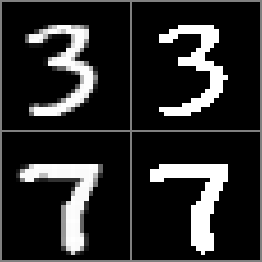

In [4]:
def display_binarization_example(dataset, i, size=128):
    images = []
    if not hasattr(i, "__len__"):
        indices = [i]
    else:
        indices = i
    for i in indices:
        a = dataset[i][0]
        images.append(a.resize((size, size), Image.NEAREST))
        ta = image_to_binarized_transform(a)
        images.append(binarized_to_image_transform((28, 28))(ta).resize((128, 128), Image.NEAREST))
    
    display(image_grid(images, border=2, w=size, h=size, nx=2, ny=len(indices), bkg=128))

display_binarization_example(mnist_train, [10000, 10002])

## Creating and Training the Network

In [5]:
data_dim = image_to_binarized_transform(mnist_train[0][0]).numel()
net = hopfield.HopfieldNetwork(data_dim)
display(f"net size: {net.size}")
help(net.fit)

'net size: 784'

Help on method fit in module hopfield_python.hopfield:

fit(X: torch.Tensor) -> torch.Tensor method of hopfield_python.hopfield.HopfieldNetwork instance
    Train the Hopfield Network.
    
    X: A `torch.Tensor` with shape `(B, N)`, where `N == self.size` and `B` is the number of examples to imprint.
    
    Returns: A weight matrix W of the trained Hopfield network. Also sets the `weights` matrix of the network to this matrix.



'Training set:'

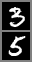

In [6]:
ex_per_label = 1
ex_labels = [3, 5]
train_set = find_data(mnist_train, ex_labels, examples_per_label=ex_per_label, random_seed=6, skip_p=0.5)
train_images = [mnist_train[i][0] for k in train_set.keys() for i in train_set[k]]
display("Training set:")
display(image_grid(train_images, border=2, w=28, h=28, nx=ex_per_label, ny=len(ex_labels), bkg=128))

In [7]:
train_tensor = make_batch(train_images)
net.fit(train_tensor)

tensor([[0.0000, 0.0026, 0.0026,  ..., 0.0026, 0.0026, 0.0026],
        [0.0026, 0.0000, 0.0026,  ..., 0.0026, 0.0026, 0.0026],
        [0.0026, 0.0026, 0.0000,  ..., 0.0026, 0.0026, 0.0026],
        ...,
        [0.0026, 0.0026, 0.0026,  ..., 0.0000, 0.0026, 0.0026],
        [0.0026, 0.0026, 0.0026,  ..., 0.0026, 0.0000, 0.0026],
        [0.0026, 0.0026, 0.0026,  ..., 0.0026, 0.0026, 0.0000]])

## Testing the Network

### Initial setup, copy/export training examples

In [8]:
ex_per_label = 1
ex_labels = [3, 5]
test_set = find_data(mnist_train, ex_labels, examples_per_label=ex_per_label, random_seed=6, skip_p=0.5)
test_images = [mnist_train[i][0] for k in test_set.keys() for i in test_set[k]]
HopfieldPattern.from_image(test_images[0]).export("./3_ok.pattern")
HopfieldPattern.from_image(test_images[1]).export("./5_ok.pattern")

In [9]:
def corrupt_and_retrieve(net: HopfieldNetwork, corruption_fn: Any, images: Iterable):
    """
    Corrupt a set of `Image`s with a `corruption_fn`, then run retrieval with a `net`.

    Returns: a list corrupt `Image`s and a corresponding list of retrieved `Image`s.
    """
    corrupt_images = list(map(corruption_fn, images))
    corrupt_batch = make_batch(corrupt_images)
    retrievals = net.forward(corrupt_batch)
    retrieved_images = list(map(binarized_to_image_transform((28, 28)), retrievals))
    return corrupt_images, retrieved_images


### Creating noisy examples

'original, noisy, retrieved'

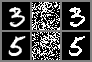

In [10]:
noisy_fn = lambda img: Image.fromarray(salt_pepper(np.array(img), prob=0.4))
noisy_images, noisy_retrieved = corrupt_and_retrieve(net, noisy_fn, test_images)
display("original, noisy, retrieved")
image_grid(tmerge(test_images, noisy_images, noisy_retrieved), border=2, w=28, h=28, nx=3, ny=ex_per_label*len(test_set), bkg=128)

### Creating blacked-out examples

'original, noisy, retrieved'

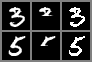

In [11]:
blackout_fn = lambda img: Image.fromarray(blackout(np.array(img), (0, 14, 28, 28)))
blackout_images, blackout_retrieved = corrupt_and_retrieve(net, blackout_fn, test_images)
display("original, noisy, retrieved")
image_grid(tmerge(test_images, blackout_images, blackout_retrieved), border=2, w=28, h=28, nx=3, ny=ex_per_label*len(test_set), bkg=128)

## Exporting the Data

In [13]:
net.export("./weights.dat")

HopfieldPattern.from_image(noisy_images[0]).export("./3_noisy.pattern")
HopfieldPattern.from_image(noisy_images[1]).export("./5_noisy.pattern")
HopfieldPattern.from_image(blackout_images[0]).export("./3_blackout.pattern")
HopfieldPattern.from_image(blackout_images[1]).export("./5_blackout.pattern")


### Debug weights matrix
Creates a "striped" weights matrix that is helpful for debugging, wherein
each weight w\[i, j\] = i + j/1000 ; the floating-point values of the
weights can be read as {row#}.{column#}.

In [15]:
__net = HopfieldNetwork(784)
w = [[float(row) + float(col)/1000.0 for col in range(0, 784)] for row in range(0, 784)]
display(w[1][783])
w = torch.tensor(w)
__net.weights = w
__net.export("./weights-striped.dat")

1.783